In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import copy

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.activation(self.layer2(x)) * 4 + 1  # Scale sigmoid output to range [1, 5]
        return x

In [ ]:
def print_matriz_com_precisao(matriz):
    matriz_np = matriz.detach().numpy() if isinstance(matriz, torch.Tensor) else np.array(matriz)
    for linha in matriz_np:
        print("[", " ".join(f"{valor:.2f}" for valor in linha), "]")

In [ ]:
def visualize_model(model, title='Model'):
    plt.figure(figsize=(8, 6))  # Define o tamanho da figura

    G = nx.DiGraph()
    total_input_nodes = 5
    total_hidden_nodes = 2
    total_output_nodes = 5

    # Mantém os neurônios da camada de entrada e saída como estão
    node_pos = {
        **{f'Input Layer_{i}': (0, -i) for i in range(total_input_nodes)},
        **{f'Output Layer_{i}': (2, -i) for i in range(total_output_nodes)}
    }

    # Centraliza e aumenta o espaçamento entre os neurônios da camada oculta
    # Calcula o offset para centralizar considerando o novo espaçamento
    offset_hidden = -(total_input_nodes - 2) / 2  # Ajusta o início para os neurônios da camada oculta
    hidden_spacing_adjustment = 1.5  # Ajusta esse valor conforme necessário para o espaçamento
    for i in range(total_hidden_nodes):
        node_pos[f'Hidden Layer_{i}'] = (1, offset_hidden - i * hidden_spacing_adjustment)

    G.add_nodes_from(node_pos.keys())

    # Inicializando o dicionário para armazenar os rótulos dos pesos das arestas
    edge_labels = {}

    # Adiciona arestas e rótulos de pesos para a primeira camada
    weights_layer1 = model.layer1.weight.data.numpy()
    for i in range(total_input_nodes):
        for j in range(total_hidden_nodes):
            G.add_edge(f'Input Layer_{i}', f'Hidden Layer_{j}')
            weight = weights_layer1[j, i]
            edge_labels[(f'Input Layer_{i}', f'Hidden Layer_{j}')] = f"{weight:.2f}"

    # Adiciona arestas e rótulos de pesos para a segunda camada
    weights_layer2 = model.layer2.weight.data.numpy()
    for i in range(total_hidden_nodes):
        for j in range(total_output_nodes):
            G.add_edge(f'Hidden Layer_{i}', f'Output Layer_{j}')
            weight = weights_layer2[j, i]
            edge_labels[(f'Hidden Layer_{i}', f'Output Layer_{j}')] = f"{weight:.2f}"

    nx.draw(G, pos=node_pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=12)
    nx.draw_networkx_edge_labels(G, pos=node_pos, edge_labels=edge_labels, font_color='red', font_size=10)

    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

In [ ]:
def treinar_modelo_global(modelo, avaliacoes, criterion, epochs=50, learning_rate=0.01):
    optimizer = optim.SGD(modelo.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = modelo(avaliacoes)
        loss = criterion(output, avaliacoes)
        loss.backward()
        optimizer.step()

In [ ]:
def treinar_modelos_locais(modelo_global, avaliacoes_inicial, criterion):
    avaliacoes_final = avaliacoes_inicial.clone()
    modelos_clientes = [copy.deepcopy(modelo_global) for _ in range(avaliacoes_inicial.size(0))]

    for i, modelo_cliente in enumerate(modelos_clientes):
        # Gerar índices de itens não avaliados
        indices_nao_avaliados = (avaliacoes_inicial[i] == 0).nonzero().squeeze()
        # Selecionar índices aleatórios para novas avaliações
        indices_novas_avaliacoes = indices_nao_avaliados[torch.randperm(len(indices_nao_avaliados))[:2]]
        # Gerar novas avaliações aleatórias
        novas_avaliacoes = torch.randint(1, 6, (2,)).float()

        # Atualizar avaliações iniciais com novas avaliações
        avaliacoes_cliente = avaliacoes_inicial[i].clone()
        avaliacoes_cliente[indices_novas_avaliacoes] = novas_avaliacoes
        avaliacoes_final[i][indices_novas_avaliacoes] = novas_avaliacoes

        print(f"\n=== Treinamento no Cliente {i + 1} ===")
        print(f"Novas Avaliações do Cliente {i + 1}:")
        print_matriz_com_precisao(avaliacoes_cliente.unsqueeze(0))

        optimizer_cliente = optim.SGD(modelo_cliente.parameters(), lr=0.01)
        for _ in range(1000):
            optimizer_cliente.zero_grad()
            output_cliente = modelo_cliente(avaliacoes_cliente.unsqueeze(0))
            loss_cliente = criterion(output_cliente, avaliacoes_cliente.unsqueeze(0))
            loss_cliente.backward()
            optimizer_cliente.step()

        with torch.no_grad():
            recomendacoes_cliente = modelo_cliente(avaliacoes_cliente.unsqueeze(0)).squeeze()
        print(f"Novas Recomendações do Cliente {i + 1} após Treinamento Local")
        print_matriz_com_precisao(recomendacoes_cliente.unsqueeze(0))

        print(f"=== Modelo do Cliente {i+1} após Treinamento Local ===")
        visualize_model(modelo_cliente, f'Modelo do Cliente {i+1}')

    # Retorna ambos: avaliações finais e os modelos dos clientes
    return avaliacoes_final, modelos_clientes

In [ ]:
def agregar_modelos_locais_ao_global_pesos(modelo_global, modelos_clientes):
    with torch.no_grad():
        for i, param_global in enumerate(modelo_global.parameters()):
            cliente_params = torch.stack([list(cliente.parameters())[i].data for cliente in modelos_clientes])
            param_global.copy_(cliente_params.mean(dim=0))

In [ ]:
print("\n=== SERVIDOR (ETAPA DE TREINAMENTO INICIAL) ===")
avaliacoes_inicial = torch.tensor([
    [4, 0, 2, 0, 3],
    [0, 3, 0, 4, 0],
    [1, 0, 0, 0, 5],
    [0, 2, 3, 0, 0]
], dtype=torch.float32)

print("=== Matriz de Avaliações Inicial (Servidor) ===")
print_matriz_com_precisao(avaliacoes_inicial)


=== SERVIDOR (ETAPA DE TREINAMENTO INICIAL) ===
=== Matriz de Avaliações Inicial (Servidor) ===
[ 4.00 0.00 2.00 0.00 3.00 ]
[ 0.00 3.00 0.00 4.00 0.00 ]
[ 1.00 0.00 0.00 0.00 5.00 ]
[ 0.00 2.00 3.00 0.00 0.00 ]


=== Modelo Global Inicial (Servidor) ===


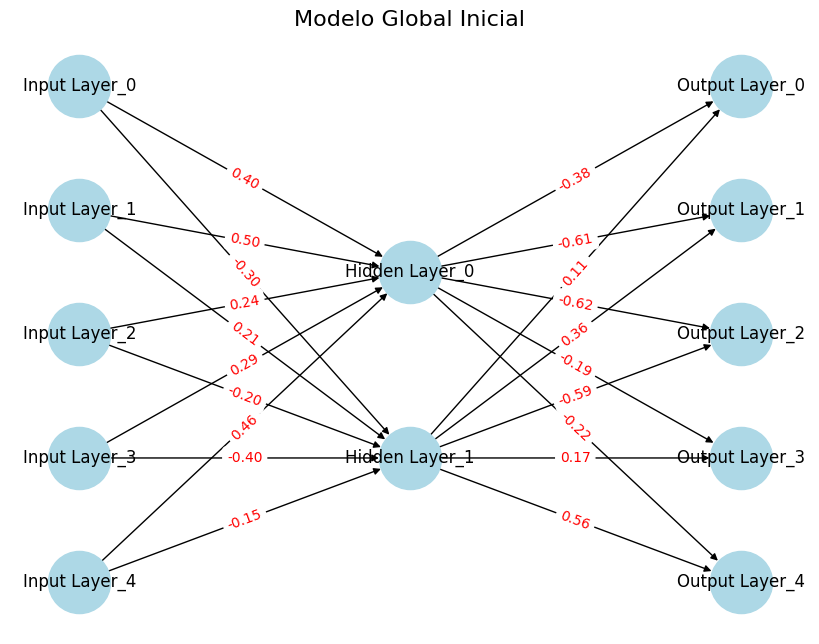

In [ ]:
modelo_global = SimpleNN(5, 2, 5)
criterion = nn.MSELoss()

# Chama a função de treinamento
treinar_modelo_global(modelo_global, avaliacoes_inicial, criterion)

print("=== Modelo Global Inicial (Servidor) ===")
visualize_model(modelo_global, 'Modelo Global Inicial')

In [ ]:
with torch.no_grad():
  recomendacoes_inicial = modelo_global(avaliacoes_inicial)

print("=== Matriz de Recomendações Inicial (Servidor) ===")
print_matriz_com_precisao(recomendacoes_inicial)

=== Matriz de Recomendações Inicial (Servidor) ===
[ 1.76 1.41 1.49 1.97 2.58 ]
[ 1.96 1.62 1.74 2.09 2.75 ]
[ 1.96 1.62 1.74 2.08 2.75 ]
[ 2.25 1.99 2.17 2.24 2.96 ]



=== CLIENTES (ETAPA DE TREINAMENTOS LOCAIS) ===

=== Treinamento no Cliente 1 ===
Novas Avaliações do Cliente 1:
[ 4.00 4.00 2.00 4.00 3.00 ]
Novas Recomendações do Cliente 1 após Treinamento Local
[ 4.00 4.00 2.00 4.00 3.00 ]
=== Modelo do Cliente 1 após Treinamento Local ===


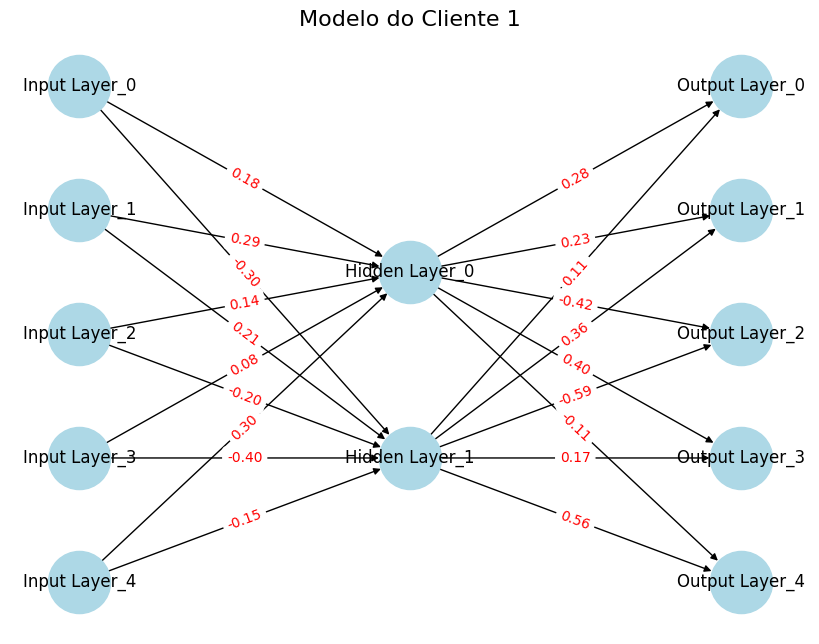


=== Treinamento no Cliente 2 ===
Novas Avaliações do Cliente 2:
[ 0.00 3.00 4.00 4.00 3.00 ]
Novas Recomendações do Cliente 2 após Treinamento Local
[ 1.00 3.00 4.00 4.00 3.00 ]
=== Modelo do Cliente 2 após Treinamento Local ===


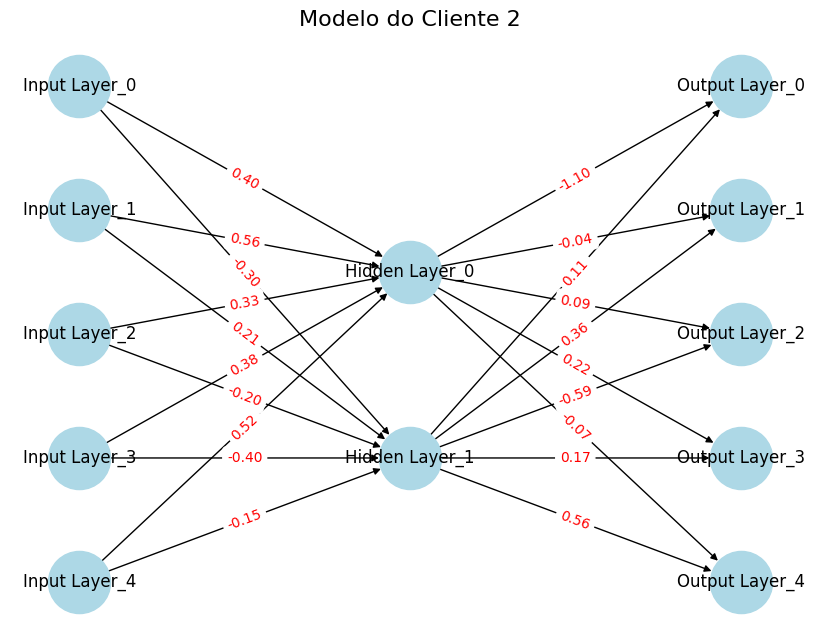


=== Treinamento no Cliente 3 ===
Novas Avaliações do Cliente 3:
[ 1.00 2.00 1.00 0.00 5.00 ]
Novas Recomendações do Cliente 3 após Treinamento Local
[ 1.03 2.00 1.02 1.00 4.96 ]
=== Modelo do Cliente 3 após Treinamento Local ===


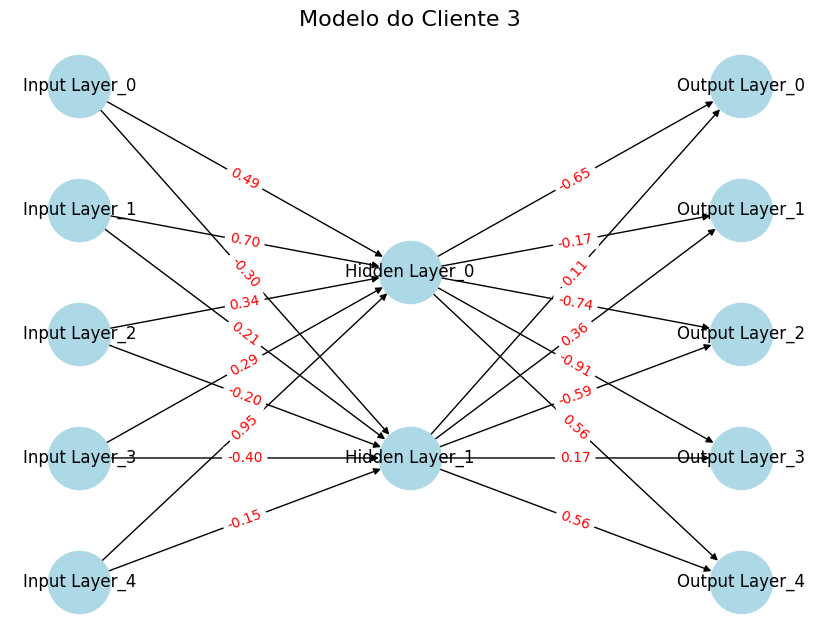


=== Treinamento no Cliente 4 ===
Novas Avaliações do Cliente 4:
[ 0.00 2.00 3.00 4.00 3.00 ]
Novas Recomendações do Cliente 4 após Treinamento Local
[ 1.00 2.00 3.00 4.00 3.00 ]
=== Modelo do Cliente 4 após Treinamento Local ===


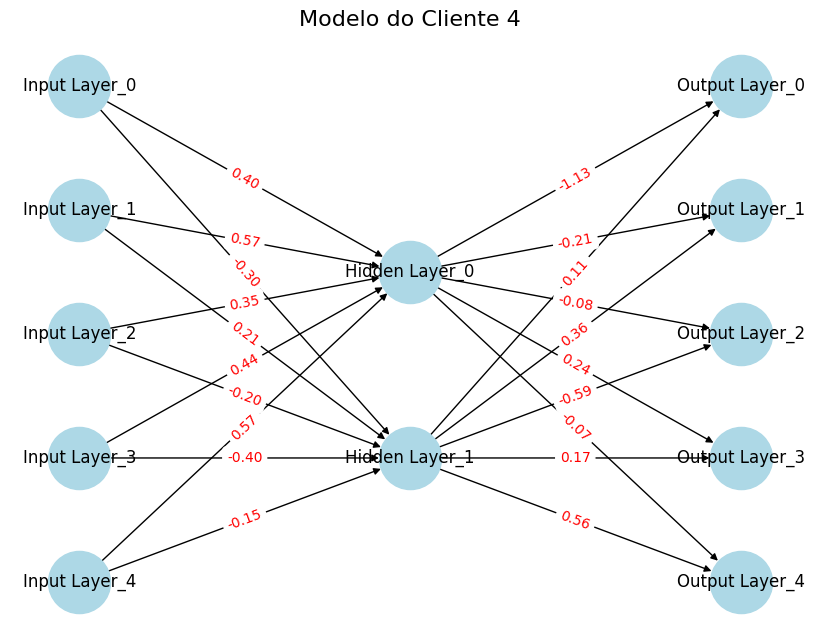

In [ ]:
print("\n=== CLIENTES (ETAPA DE TREINAMENTOS LOCAIS) ===")
avaliacoes_final, modelos_clientes = treinar_modelos_locais(modelo_global, avaliacoes_inicial, criterion)


=== Modelo Global Final (Servidor) ===


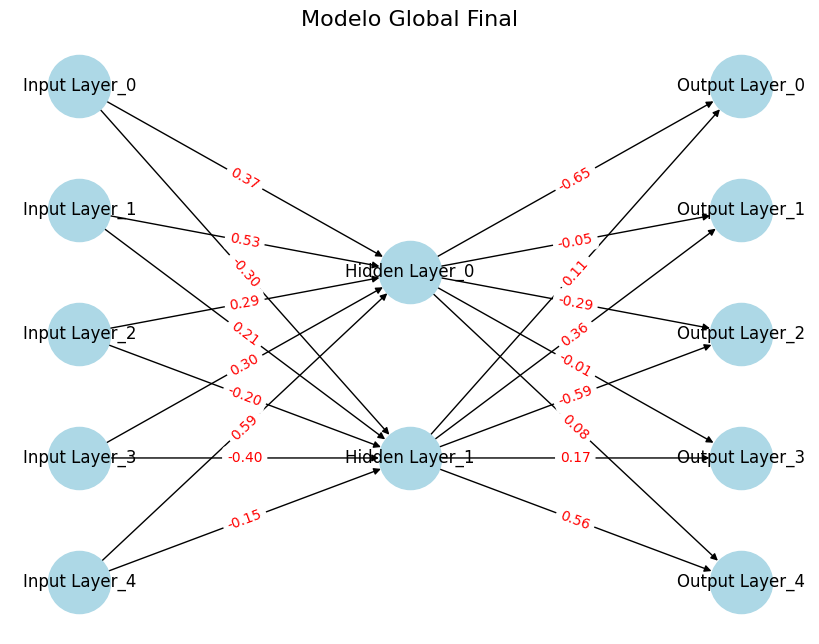

In [ ]:
# Agrega as atualizações dos modelos dos clientes ao modelo global
agregar_modelos_locais_ao_global_pesos(modelo_global, modelos_clientes)
# agregar_modelos_locais_ao_global_gradientes(modelo_global, modelos_clientes)

print("\n=== Modelo Global Final (Servidor) ===")
visualize_model(modelo_global, 'Modelo Global Final')

In [ ]:
with torch.no_grad():
    recomendacoes_final = modelo_global(avaliacoes_inicial)

print("\n=== SERVIDOR (ETAPA DE TREINAMENTO FINAL) ===")
print("=== Matriz de Avaliações Final (Servidor) *** ===")
print_matriz_com_precisao(avaliacoes_final)


=== SERVIDOR (ETAPA DE TREINAMENTO FINAL) ===
=== Matriz de Avaliações Final (Servidor) *** ===
[ 4.00 4.00 2.00 4.00 3.00 ]
[ 0.00 3.00 4.00 4.00 3.00 ]
[ 1.00 2.00 1.00 0.00 5.00 ]
[ 0.00 2.00 3.00 4.00 3.00 ]


In [ ]:
print("=== Matriz de Recomendações Final (Servidor) ===")
print_matriz_com_precisao(recomendacoes_final)

=== Matriz de Recomendações Final (Servidor) ===
[ 1.25 3.02 2.29 2.58 3.72 ]
[ 1.45 3.07 2.56 2.59 3.66 ]
[ 1.34 3.04 2.42 2.59 3.69 ]
[ 1.73 3.11 2.79 2.60 3.59 ]


In [ ]:
mse_inicial = criterion(recomendacoes_inicial, avaliacoes_inicial).item()
mse_final = criterion(recomendacoes_final, avaliacoes_final).item()

print(f"\nMSE Inicial: {mse_inicial:.4f}")
print(f"MSE Final: {mse_final:.4f}")


MSE Inicial: 3.3391
MSE Final: 1.7980
